In [1]:
# first version of radial profile code
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np
import sys as sys
mat_contents = sio.loadmat('onehund.mat') 
lfp = mat_contents["onehund"]
csdx = np.array([[0.003130],[0.003169],[0.004244],[0.003107],[0.004100],[0.005167],[0.002875],[0.003953],[0.004989],[0.006077],[0.003860],[0.004917],[0.005932],[0.004772],[0.005860],[0.005582]])
csdy = np.array([[0.002755],[0.003659],[0.002939],[0.004602],[0.003788],[0.002985],[0.005545],[0.004720],[0.003826],[0.003106],[0.005748],[0.004769],[0.003956],[0.005831],[0.004815],[0.005748]])
print(np.shape(csdx))
print("min x: ",np.min(csdx))
print("max x: ",np.max(csdx))
print("min y: ",np.min(csdy))
print("max y: ",np.max(csdy))
csd_x = np.flipud(csdx)
csd_y = np.flipud(csdy)
csd_at = np.hstack((csd_x,csd_y))
t_max = 0

(16, 1)
min x:  0.002875
max x:  0.006077
min y:  0.002755
max y:  0.005831


In [2]:
print(np.max(lfp))
print(np.min(lfp))
sigma = np.std(lfp)
mu = np.mean(lfp)

1877
-1041


In [3]:
evenind = 2*np.arange(lfp.shape[1]/2).astype(int)
oddind = (2*np.arange(lfp.shape[1]/2)+1).astype(int)
lfpeven = lfp[:,evenind]
lfpodd = lfp[:,oddind]
print(lfpeven.shape)
print(lfpodd.shape)

(16, 68)
(16, 68)


In [4]:
meanodd = np.mean(lfpodd, axis=1)
meaneven = np.mean(lfpeven, axis=1)
stdodd = np.std(lfpodd, axis=1)
stdeven = np.std(lfpeven, axis=1)
print(stdodd)

[274.80804051 258.96676852 295.73099092 276.35015838 301.29780522
 317.56830587 236.47244796 279.96919126 392.6600108  315.17493083
 263.00993804 433.98389932 307.39638414 225.50598432 292.20762455
 216.78136409]


In [5]:
print(oddind.shape[0])
print(meanodd.shape)
print(lfp[1,oddind].shape)

68
(16,)
(68,)


In [6]:
lfp2 = np.zeros((16,136))
for i in range(meanodd.shape[0]):
    lfp2[i,oddind] = (1*stdodd[i])*np.random.randn(oddind.shape[0])+meanodd[i]
for i in range(meaneven.shape[0]):
    lfp2[i,evenind] = (1*stdeven[i])*np.random.randn(evenind.shape[0])+meaneven[i]
print(lfp2.shape)

(16, 136)


In [7]:
lfp = lfp2

In [8]:
from scipy.interpolate import griddata
start = 0 #1280 #6030; #6030; #4981 #5980 #11500 #5990 #6010;
end = lfp.shape[1];
print(end)
dt = 0.003;
#n = end-start+1
n=lfp.shape[1]-1 #299 #100; #999;  #10;
lfp1=np.reshape(lfp[:,start],(-1,1))
grid_x, grid_y = np.mgrid[0.0031:0.0055:100j,                                                                                                                                                           
                  0.0031:0.0055:100j]

grid_z = griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic') 
for x in range(n):  
    lfp1=np.reshape(lfp[:,start+1+x],(-1,1))  # start+1 because grid_z(:,:,0) already created  
    grid_z = np.dstack((grid_z,griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic'))) #"cubic")))
    t_max_tmp = np.nanmax(np.abs(grid_z[:,:,x]))
    if t_max_tmp > t_max:
        t_max=t_max_tmp
print(t_max)
print(np.shape(grid_x))
print(np.shape(grid_y))
print(np.shape(grid_z))

136
1575.2001940122564
(100, 100)
(100, 100)
(100, 100, 136)


In [9]:
cx = (int) (grid_z.shape[0]/2)
cy = (int) (grid_z.shape[1]/2)

In [10]:
import math
import copy
import scipy.signal as scp
lfpmaxangle = []
lfpminangle = []
lfpmaxval = []
lfpminval = []
lfpradprof = []
for num in range(n):
    #Normalization
    img = copy.deepcopy(grid_z[:,:,num])
    #img = img-minval
    #img = img/(maxval-minval)
    #img = img-np.min(img)
    #img = img/(np.max(img)-np.min(img))
    for x in range(grid_z.shape[0]):
        for y in range(grid_z.shape[1]):
            if((x-cx)*(x-cx)+(y-cy)*(y-cy)>2500):
                img[x,y] = 0;
    f = np.fft.fft2(img)
    
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img = np.rot90(img)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_b = np.rot90(img_back)
    radii = []
    sumradii1 = []
    sumradii2 = []
    for r in range(360):
        width = magnitude_spectrum.shape[0]
        height = magnitude_spectrum.shape[1]
        theta = 2 * math.pi * r / 360;
        dx = (math.cos(theta));
        dy = (math.sin(theta));
        w2 = width * width / 4;
        h2 = height * height / 4;
        m = math.sqrt(w2 * h2 / (dx * dx * h2 + dy * dy * w2));
        x = (cx + m * dx);
        y = (cy + m * dy);
        distance = math.sqrt((x-cx)*(x-cx)+(y-cy)*(y-cy))
        nr = 20;
        radialsum1 = 0;
        radialsum2 = 0;
        for s in range(1,nr):
            sx = (int)(cx + s*distance/nr*dx)
            sy = (int)(cy + s*distance/nr*dy)
            radialsum1 = radialsum1 + grid_z[sx,sy,num];
            radialsum2 = radialsum2 + magnitude_spectrum[sx,sy];
        radii.append(r);
        sumradii1.append(radialsum1);
        sumradii2.append(radialsum2);
    print('Image '+str(num))
    print('Max located at: '+str(radii[np.argmax(sumradii1)])+" degrees, Val: "+str(np.max(sumradii1)))
    print('Min located at: '+str(radii[np.argmin(sumradii1)])+" degrees, Val: "+str(np.min(sumradii1)))
    filtsumrad2 = scp.savgol_filter(sumradii2, 53, 3) #FFT Magnitude Spectrum Filtered
    lfpmaxangle.append(radii[np.argmax(sumradii1)])
    lfpminangle.append(radii[np.argmin(sumradii1)])
    lfpmaxval.append(np.max(sumradii1))
    lfpminval.append(np.min(sumradii1))
    lfpradprof.append(sumradii1)

Image 0
Max located at: 90 degrees, Val: -1255.2909210371135
Min located at: 235 degrees, Val: -6456.454455374044
Image 1
Max located at: 305 degrees, Val: 11579.169362241208
Min located at: 115 degrees, Val: -3043.4511032867026
Image 2
Max located at: 329 degrees, Val: 4180.862340568239
Min located at: 90 degrees, Val: 206.33814155385372
Image 3
Max located at: 115 degrees, Val: 9841.169847214262
Min located at: 250 degrees, Val: -554.66550351426
Image 4
Max located at: 115 degrees, Val: 9511.505674352433
Min located at: 260 degrees, Val: -6303.668854290447
Image 5
Max located at: 54 degrees, Val: 14388.89329840527
Min located at: 258 degrees, Val: 7338.313210350847
Image 6
Max located at: 259 degrees, Val: 3414.077343473337
Min located at: 132 degrees, Val: -7428.683063514848
Image 7
Max located at: 259 degrees, Val: 14736.012771446687
Min located at: 132 degrees, Val: -2238.9220181385845
Image 8
Max located at: 245 degrees, Val: 4141.512943711541
Min located at: 12 degrees, Val: -62

Image 78
Max located at: 250 degrees, Val: -146.0752860528214
Min located at: 118 degrees, Val: -2898.00841050312
Image 79
Max located at: 36 degrees, Val: 6206.1889616674725
Min located at: 132 degrees, Val: -3803.507339345554
Image 80
Max located at: 36 degrees, Val: 3720.079032711025
Min located at: 138 degrees, Val: -4653.24023978329
Image 81
Max located at: 324 degrees, Val: 12833.137832099996
Min located at: 211 degrees, Val: 6424.788721901072
Image 82
Max located at: 305 degrees, Val: 4045.607114811484
Min located at: 48 degrees, Val: -538.7965416761793
Image 83
Max located at: 271 degrees, Val: 13149.742008092478
Min located at: 102 degrees, Val: 4507.171583772722
Image 84
Max located at: 45 degrees, Val: 1893.6746372261184
Min located at: 249 degrees, Val: 86.50161429297285
Image 85
Max located at: 17 degrees, Val: 11455.657258247047
Min located at: 138 degrees, Val: 5089.179708087529
Image 86
Max located at: 339 degrees, Val: 810.7542446074124
Min located at: 235 degrees, Val

In [11]:
# Convert lists to array
lfpmaxangle = np.asarray(lfpmaxangle)
lfpminangle = np.asarray(lfpminangle)
lfpmaxval = np.asarray(lfpmaxval)
lfpminval = np.asarray(lfpminval)
lfpradprof = np.asarray(lfpradprof)

In [12]:
# Correlation of Correlations 
#(i.e. correlation coef for if pre correlation high then is post correlation high)
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(num+1,n):
        if(num%2==0 and num2%2==0 and num<134 and num2<134):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
print(len(corrind))
print(len(corrind2))
print(np.corrcoef(corrind, corrind2))

2211
2211
[[ 1.         -0.03324749]
 [-0.03324749  1.        ]]


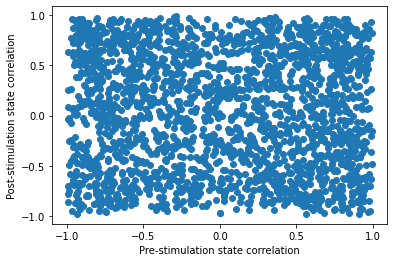

In [13]:
plt.scatter(corrind, corrind2)
plt.rcParams.update({'font.size': 14})
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Pre-stimulation state correlation')
plt.ylabel('Post-stimulation state correlation')
plt.show()

In [14]:
from scipy.stats import linregress
linregress(corrind, corrind2)

LinregressResult(slope=-0.031707424144154756, intercept=0.04228723269876073, rvalue=-0.03324748803133235, pvalue=0.11807913901436443, stderr=0.020279820165756347)

In [15]:
# Correlation of Pre and Post States
corrind3 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [16]:
# Correlation Heatmap
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [17]:
print(n)

135


In [18]:
corrmat = np.asarray(corrind).reshape((int(n/2)+1,int(n/2)+1))
corrmat2 = np.asarray(corrind2).reshape((int(n/2),int(n/2)))

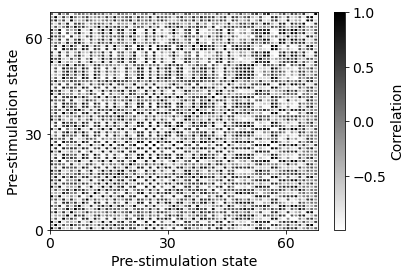

In [19]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Pre-stimulation state')
plt.ylabel('Pre-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
#plt.title('Heatmap of Pre-stimulation Radial Profile Correlation')
fig.colorbar(im, label='Correlation')
plt.show()

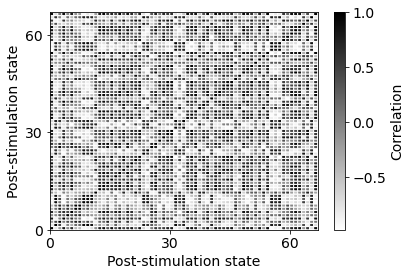

In [20]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat2, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
fig.colorbar(im, label='Correlation')
#plt.title('Heatmap of Post-stimulation Radial Profile Correlation')
plt.xlabel('Post-stimulation state')
plt.ylabel('Post-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
plt.show()

In [21]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    print('Image '+str(num))
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            print(str(num2)+': '+str(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]))
            corr.append(num2)
            if(num<134 and num2<134):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2==0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

Image 0
20: 0.9381675235124377
Image 1
69: 0.9072503327229849
109: 0.9498309462643639
133: 0.9295761806708839
Image 2
132: 0.9551396096805048
Image 3
17: 0.9054617681902684
19: 0.9760942081828794
Image 4
26: 0.9166106093635721
52: 0.9847011276601134
104: 0.9567643288800755
Image 5
51: 0.9520660454456278
Image 6
44: 0.9093688152092406
72: 0.9552923713484003
76: 0.9095052647292188
94: 0.963905277781219
114: 0.9228827884138031
Image 7
57: 0.9020256780542147
79: 0.9649451855682188
99: 0.9480524637541389
Image 8
102: 0.9586502348313348
Image 9
Image 10
130: 0.9143160252235197
132: 0.9282731126091155
Image 11
Image 12
Image 13
15: 0.9748408529658215
Image 14
30: 0.939250736616564
42: 0.9138426931290098
62: 0.9096691192591513
118: 0.9025976453121739
122: 0.9260241274764546
Image 15
Image 16
60: 0.9013616496562182
78: 0.91833586731153
Image 17
19: 0.9187907207859107
21: 0.9350949478611666
Image 18
Image 19
63: 0.9585260790539081
Image 20
26: 0.9505151038869902
36: 0.9279047088848158
48: 0.9286

In [22]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            corr.append(num2)
            if(num>0 and num2>0 and num%2==1):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2!=0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

In [23]:
numpostcorr

33

In [24]:
num/2

67.0

In [25]:
contextdependent

[0.3333333333333333,
 0.5,
 0.0,
 0.6666666666666666,
 -1,
 -1,
 0.0,
 -1,
 0.5,
 0.0,
 0.0,
 1.0,
 0.75,
 0.25,
 0.0,
 0.5,
 -1,
 0.8,
 1.0,
 -1,
 -1,
 -1,
 0.6,
 -1,
 1.0,
 -1,
 0.5,
 -1,
 -1,
 0.4,
 0.4,
 0.6666666666666666,
 -1,
 -1,
 -1,
 0.3333333333333333,
 0.6666666666666666,
 0.0,
 1.0,
 0.0,
 -1,
 0.6666666666666666,
 1.0,
 -1,
 0.0,
 0.0,
 -1,
 -1,
 0.0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.5,
 0.0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [26]:
len(np.argwhere(np.asarray(contextdependent)>0.7))

7

In [27]:
#Repeat but shuffle prestates
shuffledarr = 2*np.arange(n/2).astype(int)
#Permutation
ncdpermutation = []
ncdpermmean = []
for perm in range(1000):
    np.random.shuffle(shuffledarr)
    numpostcorr = 0
    contdepmeans = []
    contextdependent = []
    for num in np.arange(n):
        corr = []
        precorr = []
        for num2 in np.arange(num+1, n):
            if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
                corr.append(num2)
                if(num>0 and num2>0 and num%2==1):
                    precorr.append(np.corrcoef(lfpradprof[shuffledarr[(int)((num-1)/2)]], lfpradprof[shuffledarr[(int)((num2-1)/2)]])[0, 1])
        if(num%2!=0):
            if(len(corr)==0):
                contextdependent.append(-1)
            else:
                numpostcorr = numpostcorr+1
                nprecorr = len(np.argwhere(np.asarray(precorr)>0))
                contdepmeans.append(np.mean(precorr))
                contextdependent.append(nprecorr/len(corr))
    print(perm)
    ncdpermutation.append(len(np.argwhere(np.asarray(contextdependent)>0.7)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
print(np.mean(ncdpermutation))

10.663


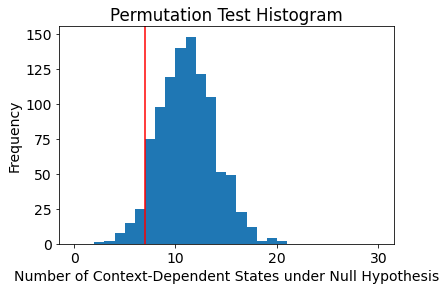

In [29]:
plt.hist(np.asarray(ncdpermutation), bins=30, range=(0,30))
plt.axvline(x=7).set_color('red')
plt.xticks([0,10,20,30])
plt.title('Permutation Test Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Context-Dependent States under Null Hypothesis')
plt.show()

In [30]:
len(np.argwhere(np.asarray(ncdpermutation)>7))

874

In [31]:
np.std(ncdpermutation)

2.7672063529849016